# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [34]:
batch_size = 100
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Files already downloaded and verified


In [35]:
for i, (data,target) in enumerate(train_loader):
  print(data.shape)
  print(type(target))
  break

torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'>


In [51]:
class Net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1,padding=1)
        self.act1=nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 1,padding=1)
        self.max_pool2=nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)
        #Flatten in forward function
        self.fc1 = nn.Linear(16384, 128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        #torch.Size([64, 3, 32, 32])
        x = self.conv1(x)
        #torch.Size([64, 32, 32, 32])
        x = self.act1(x)
        x = self.conv2(x)
        #torch.Size([64,64,32,32])
        x = self.max_pool2(x)
        #torch.Size([64, 64, 16, 16])
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        #torch.Size([64, 16384])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        #x = self.act3(x)
        #torch.Size([64, 10])
        return x

In [45]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for data,target in train_dataset:
            data=data.to(device)
            target=target.to(device)
            optimizer.zero_grad()   # zero the gradient buffers
            output = network(data)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.cpu().numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

In [52]:
def test(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Epoch        0 Loss: 1.508730169057846
Epoch        1 Loss: 1.1753930938243866
Epoch        2 Loss: 1.0483304728269578
Epoch        3 Loss: 0.9516425919532776
Epoch        4 Loss: 0.8875651352405548
Epoch        5 Loss: 0.8197824597358704
Epoch        6 Loss: 0.7709039905667305
Epoch        7 Loss: 0.7307294963002204
Epoch        8 Loss: 0.68124217659235
Epoch        9 Loss: 0.6298384914398193
Epoch       10 Loss: 0.5940608960986138
Epoch       11 Loss: 0.5691893176436424
Epoch       12 Loss: 0.5382691284418106
Epoch       13 Loss: 0.5145950546264648
Epoch       14 Loss: 0.4839957937002182
Epoch       15 Loss: 0.4678484289050102
Epoch       16 Loss: 0.45377194428443907
Epoch       17 Loss: 0.43790816980600356
Epoch       18 Loss: 0.4279299075603485
Epoch       19 Loss: 0.40227016305923463
Epoch       20 Loss: 0.3993542747497559
Epoch       21 Loss: 0.38513504034280777
Epoch       22 Loss: 0.3761931505203247
Epoch       23 Loss: 0.3664820244908333
Epoch       24 Loss: 0.3627102637887001

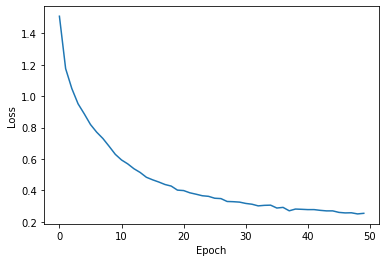

In [54]:
net = Conv_net().to(device)
EPOCHS_TO_TRAIN = 50
train(network=net, 
      train_dataset=train_loader, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.001))

#**train** and **test** functions that I don't understand

In [15]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive):
    train_loss = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()
        loss= loss(output,target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item ()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss / len(test_loader)
    loss_archive.append (test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
epochs          = 100
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

#model = Simple_net(100, 10).to(device)
model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    test(model, device, test_loader, test_loss)
    scheduler.step()

    #plt.figure (figsize=(24, 15))
    
    #plt.plot (train_loss, 'r')
    #plt.plot (test_loss, 'g')
    #plt.ylim(ymin=0)

    #plt.show ()

    #plt.pause (0.01)
    #clear_output(wait = True)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303771
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.224361
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.215011
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.239800
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.178665
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.136607
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.174968
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.071078

Test set: Average loss: -0.3557, Accuracy: 3793/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.065658
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.148030
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.115513
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.056143
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.098311
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.050223
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.103253
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.002676

Test set: Average loss: -0.3993, Accuracy: 4167/10000 (42%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.026276
Train Epoch: 3 [6400/50000 (13%)]	Loss: 2.0

KeyboardInterrupt: ignored